A supplementary notebook to 01 - Sendai Map to produce graphics for presentations and reports.

In [26]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon, Point
import os, io, sys
import numpy as np
import ujson as json
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import fiona
from functools import reduce
from scipy.optimize import linprog
from scipy.sparse import csr_matrix

# Remove this when debugging
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.__version__

#if not os.path.exists("temp/"):
#    os.makedirs("temp/")


'1.3.0'

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Road Network Map of Sendai, Japan')

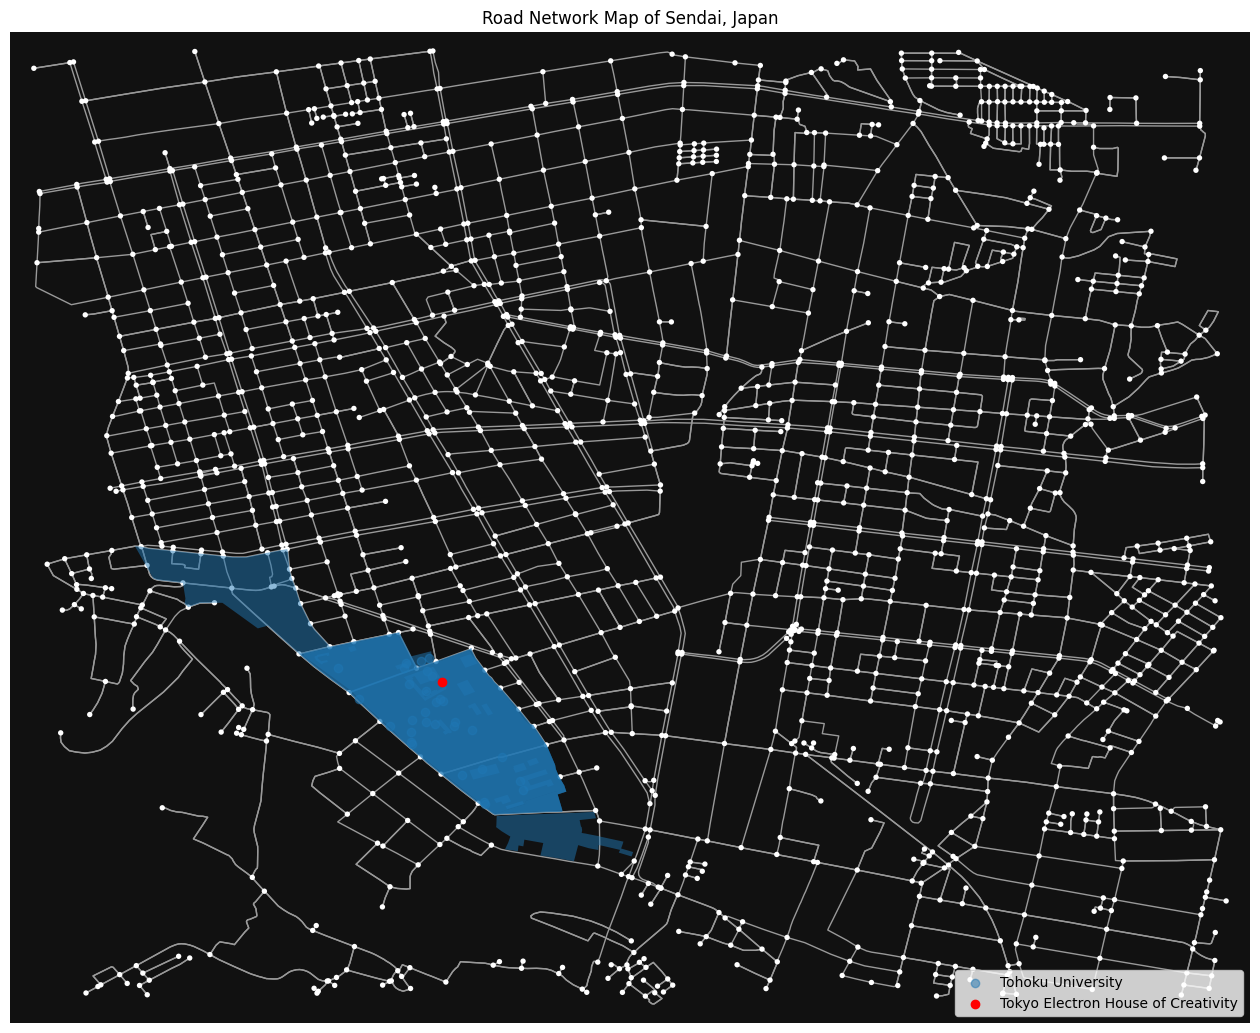

In [27]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='drive')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.set_title('Road Network Map of Sendai, Japan')

ax.legend(handles=[ax.collections[4],ax.collections[5]],
          labels=['Tohoku University', 'Tokyo Electron House of Creativity'],
          loc = 'lower right')

In [28]:
## We have some preprocessing to do first.

# Read the gpx directly
tripdata_nodes = gpd.read_file('Data/7-15-2022.gpx', layer = 'track_points')
    
# Read the IMU data directly
with open('Data/imu7-15-22 2_16_02.csv', mode = 'r') as f:
    tripdata_imu = csv.reader(f)
    tripdata_imu = pd.DataFrame(tripdata_imu)

# First we clean up the tripdata
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (pd.to_datetime(tripdata_nodes['time']) - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata_nodes.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'sat', 'geometry']]

# We will need the edges for FMM, so I wrote a helper function to create edges from points
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})

# Now lets work on the IMU data.

tripdata_imu[0] = tripdata_imu[0].astype(float)

accel = []
for i in range(len(tripdata_imu)):
    row = tripdata_imu[[2,3,4]].loc[0]
    accel.append((float(tripdata_imu[[2,3,4]].loc[i].iloc[0]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[1]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[2])))

    
#tripdata_imu = tripdata_imu.rename(columns = {'0':'timestamp', '})

# We need to convert the times to UNIX timestamps.
    
timediff = dt.strptime('2022-07-15T02:16:02', '%Y-%m-%dT%H:%M:%S').timestamp() - float(tripdata_imu[0][0])

# Not going to overwrite tripdata_imu yet because we haven't done gyro yet
newdf = pd.DataFrame({'timestamp': tripdata_imu[0] + timediff, 'accelerometer' : accel,})

# We will separate the gyroscope data for later because it isn't synchronous with the rest of the data
# We will simply fuse this at the end

gyro = []
gyrotime = []

for i in range(len(tripdata_imu)):
    if tripdata_imu[5].loc[i] is not None:
        if float(tripdata_imu[5].loc[i]) == 4:
            gyrotime.append(float(newdf['timestamp'].loc[i]))
            gyro.append((float(tripdata_imu[[6,7,8]].loc[i].iloc[0]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[1]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[2])))

tripdata_gyro = pd.DataFrame({'timestamp':gyrotime, 'gyroscope':gyro})

tripdata_imu = newdf


In [29]:
tripdata_nodes = mm_utils.fuse(mm_utils.fuse(tripdata_nodes, tripdata_imu, 'timestamp', 'nearest neighbor'), tripdata_gyro, 'timestamp', 'nearest neighbor')

Text(0.5, 1.0, 'Example Trajectory in Road Network of Sendai')

<Axes: title={'center': 'Example Trajectory in Road Network of Sendai'}>

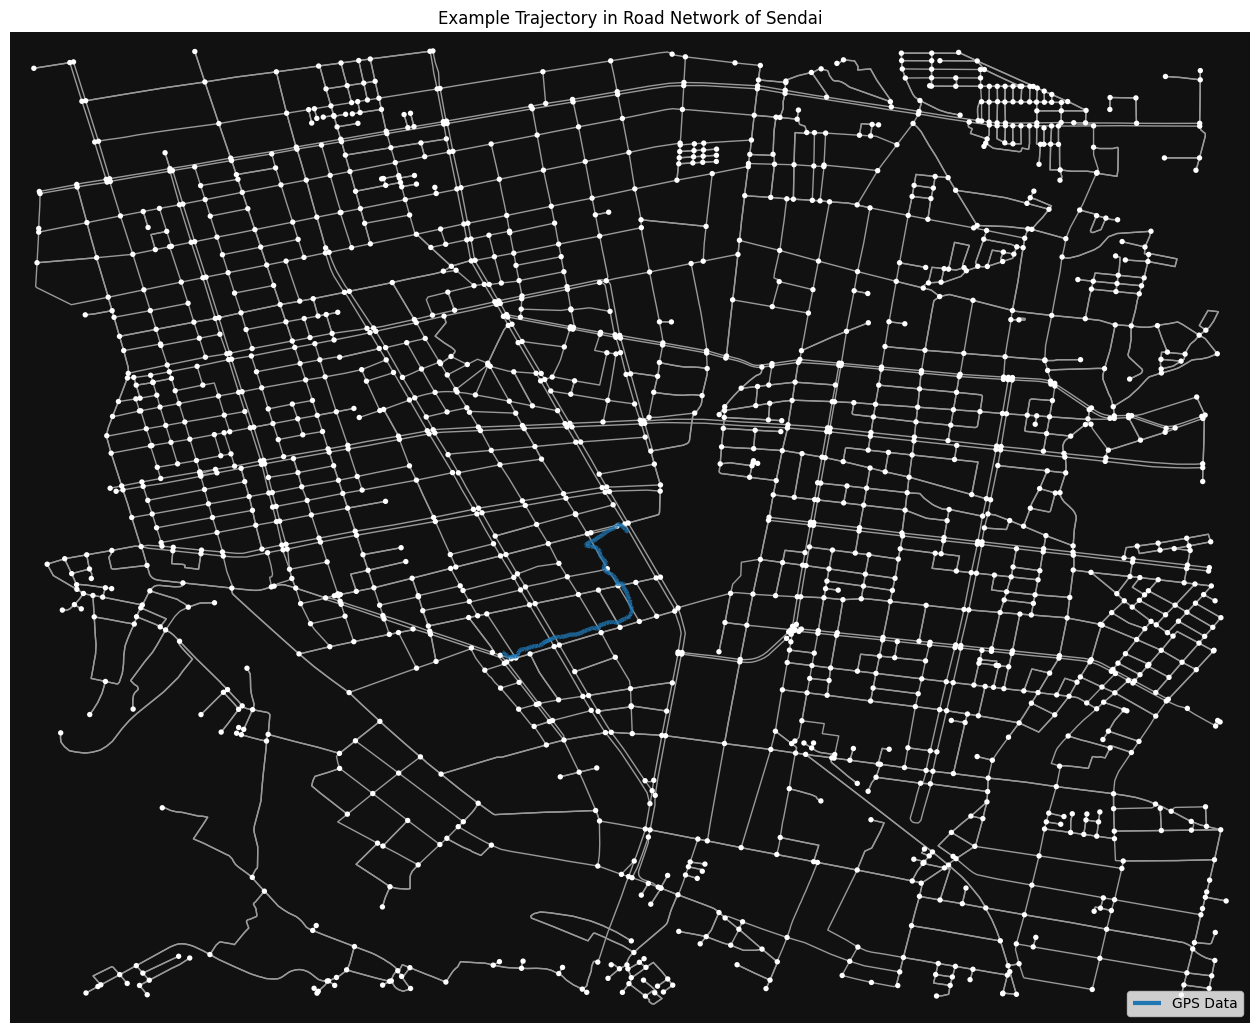

In [30]:
fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False, close=False)
#tripdata_nodes.plot(ax=ax)

ax.set_title('Example Trajectory in Road Network of Sendai')

tripdata_edges.plot(ax=ax, linewidth=3)
ax.legend(handles=[ax.collections[2]],labels=['GPS Data'], loc = 'lower right')

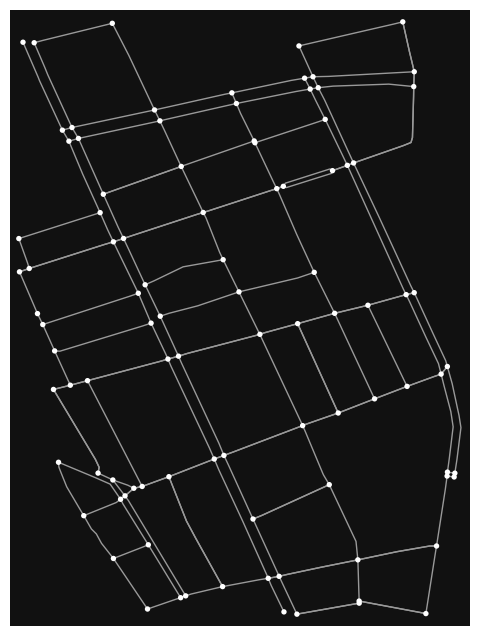

In [31]:
smallnetwork = mm_utils.df_to_network(tripdata_nodes, as_gdf = False)
fig, ax = ox.plot_graph(smallnetwork, figsize=(16,8))
#ax.set_title('Road Network')

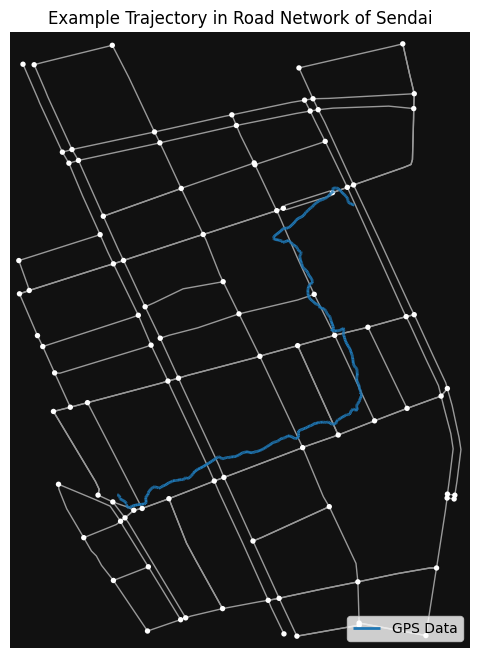

In [32]:
fig, ax = ox.plot_graph(smallnetwork, figsize=(16,8), show=False)
tripdata_edges.plot(ax=ax, linewidth=2, aspect=None)
#tripdata_nodes.plot(ax=ax, markersize=1) # Don't really need to plot this, there's so many nodes that it looks identical to the edges
ax.set_title('Example Trajectory in Road Network of Sendai')
ax.legend(handles=[ax.collections[2]],labels=['GPS Data'], loc = 'lower right')
#plt.savefig('test123.png', dpi=100)
plt.plot();

In [33]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(smallnetwork)

,y,x,highway,street_count,geometry
osmid,,,,,
244879418,38.260102,140.875203,traffic_signals,4,POINT (140.87520 38.26010)
301789618,38.255104,140.875946,NaN,4,POINT (140.87595 38.25510)
338511382,38.257388,140.878403,traffic_signals,4,POINT (140.87840 38.25739)
338511384,38.260786,140.879291,traffic_signals,4,POINT (140.87929 38.26079)
338511385,38.257086,140.876968,traffic_signals,4,POINT (140.87697 38.25709)
...,...,...,...,...,...
5824799263,38.257976,140.878034,NaN,4,POINT (140.87803 38.25798)
5824799266,38.257639,140.876645,NaN,3,POINT (140.87665 38.25764)
7818121674,38.254456,140.881520,NaN,3,POINT (140.88152 38.25446)


osmid  oneway lanes   name      highway   
u          v          key                                                
244879418  1201358483 0     30999231    True     4    青葉通     tertiary  \
           1256397159 0    899682371    True   NaN  東二番丁通        trunk   
301789618  2327862877 0     30614285   False   NaN   北目町通     tertiary   
           1264086390 0     32896012    True     2    五橋通     tertiary   
           1256650347 0    667827062    True   NaN    NaN  residential   
...                              ...     ...   ...    ...          ...   
7818121674 1256553930 0    223942227    True     3  愛宕上杉通     tertiary   
8078650819 8078650820 0     38813037    True     2    南町通     tertiary   
           361821043  0    866721535   False     4    南町通     tertiary   
8078650820 8078650819 0    837984432    True     2    南町通     tertiary   
           361062275  0    866721533   False     4    南町通     tertiary   

                          reversed   length  ref maxspeed   
u          v          key                                   
244879418  1201358483 0      False   15.304  NaN      NaN  \
           1256397159 0      False   94.102  286       60   
301789618  2327862877 0      False    8.585  NaN      NaN   
           1264086390 0      False  114.691  NaN      NaN   
           1256650347 0      False   62.368  NaN      NaN   
...                            ...      ...  ...      ...   
7818121674 1256553930 0      False  108.973  NaN      NaN   
8078650819 8078650820 0      False   82.420  NaN       40   
           361821043  0       True   24.296  NaN       40   
8078650820 8078650819 0      False   82.459  NaN       40   
           361062275  0       True   10.795  NaN       40   

                                                                    geometry  
u          v          key                                                     
244879418  1201358483 0    LINESTRING (140.87520 38.26010, 140.87503 38.2...  
           1256397159 0    LINESTRING (140.87520 38.26010, 140.87564 38.2...  
301789618  2327862877 0    LINESTRING (140.87595 38.25510, 140.87602 38.2...  
           1264086390 0    LINESTRING (140.87595 38.25510, 140.87576 38.2...  
           1256650347 0    LINESTRING (140.87595 38.25510, 140.87587 38.2...  
...                                                                      ...  
7818121674 1256553930 0    LINESTRING (140.88152 38.25446, 140.88167 38.2...  
8078650819 8078650820 0    LINESTRING (140.87968 38.25966, 140.87967 38.2...  
           361821043  0    LINESTRING (140.87968 38.25966, 140.87971 38.2...  
8078650820 8078650819 0    LINESTRING (140.87882 38.25944, 140.87885 38.2...  
           361062275  0    LINESTRING (140.87882 38.25944, 140.87880 38.2...  

[191 rows x 10 columns]

,ele,timestamp,sat,geometry,accelerometer,gyroscope
0,40.228,1657818983,12,POINT (140.87589 38.25547),"(0.62, 4.135, 5.575)","(-0.169, 0.13, 0.439)"
1,40.088,1657818984,12,POINT (140.87590 38.25547),"(-1.281, 4.524, 4.876)","(-0.046, -0.23, 0.357)"
2,39.078,1657818985,12,POINT (140.87591 38.25547),"(-1.31, 4.314, 5.49)","(-0.03, -0.045, 0.211)"
3,38.216,1657818986,11,POINT (140.87592 38.25546),"(-0.946, 3.999, 8.539)","(0.118, 0.316, 0.056)"
4,37.390,1657818987,11,POINT (140.87592 38.25545),"(-1.448, 3.266, 9.106)","(-0.111, 0.047, 0.241)"
...,...,...,...,...,...,...
640,44.856,1657819623,13,POINT (140.87999 38.25951),"(-1.587, 1.319, 11.022)","(-0.421, -0.097, 0.094)"
641,45.039,1657819624,13,POINT (140.88001 38.25950),"(-1.587, 1.319, 11.022)","(-0.421, -0.097, 0.094)"
642,46.311,1657819625,13,POINT (140.88003 38.25949),"(-1.587, 1.319, 11.022)","(-0.421, -0.097, 0.094)"
643,46.356,1657819626,13,POINT (140.88005 38.25949),"(-1.587, 1.319, 11.022)","(-0.421, -0.097, 0.094)"


In [34]:
%%time

#from algorithms import fmm_bin
#from fmm import FastMapMatchConfig
### Define map matching configurations

#k = 16
#radius = 0.003
#gps_error = 0.0005

# create a text trap and redirect stdout
#text_trap = io.StringIO()
#sys.stdout = text_trap

#fmm_config = FastMapMatchConfig(k,radius,gps_error)
#cfg_file = None



#fmm_sim = fmm_bin.FMM(cfg = fmm_config)

#fmm_sim.run(tripdata_edges)

# now restore stdout function
#sys.stdout = sys.__stdout__

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.25 µs


In [35]:

#mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = fmm_sim.results, fs = (16,16))
#plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','FMM Predicted Route'], loc = 'lower right')
#plt.gca().set_title('FMM Prediction')

This is pretty bad. The issue is that FMM (and other Hidden Markov Model approaches) do not perform well with an overabundance of data. Even small deviations with lots of datapoints dominate, and the algorithm tries to match it to roads it shouldn't.

This is where a geometric method performs better. If we work with nodes, these small deviations do not affect the loss much on average, so they are effectively ignored. If we work with a polyline, then the amount of nodes becomes entirely irrelevant, and so geometric methods are far more flexible when datapoint quantity may vary.

In [36]:
from algorithms import metric_mm

### Define map matching configurations

## Least squares functions
ls_ri = lambda distarray: np.square(distarray) # The function applied directly to the distances from the candidate route to the k-NN GPS coords
ls_ro = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray)) # This is where we 'integrate' over the distances, and if we need to do anything else, we do it
ls_gi = lambda distarray: np.square(distarray) # The function applied directly to the distances from the GPS coords to the k-NN candidate route nodes
ls_go = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray))
##

## Inverse squares function ('Electrical method')
eps = 0.01
is_ri = lambda distarray: np.power(np.square(distarray) + eps, -1) # We need eps to prevent singularities, i.e. r = 0
is_ro = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray)) # We sum, and then multiply by -1 to turn the minimizing process into a maximizing process
is_gi = lambda distarray: np.power(np.square(distarray) + eps, -1)
is_go = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray))
##

def wrapper_f(ri, ro, gi, go): # This should return a function composed from the basic functions, that can then be applied onto route and gps data.
    return lambda route, gps : 1*ro(ri(route)) + 1*go(gi(gps))

ls_loss_function = wrapper_f(ls_ri, ls_ro, ls_gi, ls_go)
is_loss_function = wrapper_f(is_ri, is_ro, is_gi, is_go)

def wasserstein(routeloss, gpsloss):#gpsloss,n,m
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    # n is the number of points along the trajectory
    # m is the number of points on the candidate route
#    print(gpsloss.shape)
    n = gpsloss.shape[0]
    m = gpsloss.shape[1]
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    #Create equality constraints
    b = [1/n for i in range(0,n)]+ [1/m for i in range(0,m)]
    row1 = [i for i in range(0,n) for j in range(0,m)]
    row2 = [n+j for j in range (0,m) for i in range(0,n)]
    row = np.append(np.matrix.flatten(np.array(row1)),np.matrix.flatten(np.array(row2)))
    col1 = [list(range(0,n*m))]
    col2 =  [j+m*k for j in range(0,m) for k in range(0,n)]
    col = np.append(np.matrix.flatten(np.array(col1)),np.matrix.flatten(np.array(col2)))
    data = np.ones(n*m*2)
    A = csr_matrix((data, (row, col)),shape = (n+m, n*m)).toarray()
    A = A[:-1]
    b = b[:-1]
    #solve the linear program
    res = linprog(np.matrix.flatten(gpsloss),None, None,A,b)
    #return the function value, i.e. the wasserstein distance
    loss = res.fun
    return loss

In [37]:
sim2 = metric_mm.Sim(ls_ri, ls_ro, ls_gi, ls_go, wrapper_f) # Least squares metric-based
sim3 = metric_mm.Sim(loss_function = is_loss_function)
sim4 = metric_mm.Sim(loss_function = wasserstein)

Before we use the simulators, we will do some preprocessing steps first. While the simulators have a built-in pre-processing stage, it is still better to compute candidate routes separately and then give it to the simulator. This is because we can choose our parameters for candidate routes better than the assumed defaults. This will also cut down on the pre-processing computation time as we can reuse the candidate routes with multiple simulators.

In [38]:
%%time

print('Preprocessing Candidate Routes')

qry_pts = [y for sublist in [x.coords[:] for x in gdf_edges['geometry']] for y in sublist]            
source_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[0].x, tripdata_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
source_index = source_index[0][0]
target_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[-1].x, tripdata_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
target_index = target_index[0][0]

source = Point(qry_pts[source_index])
target = Point(qry_pts[target_index])

candidates = mm_utils.get_nearest_edges(tripdata_nodes, gdf_edges, k_neighbors=8, r = 0.01) # If r is too large it will run slow, as getting nearest edges is computationally difficult
    # I recommend starting with small values that yield less than k k_neighbors, and slowly increase from there
all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)
candidate_routes, _ = mm_utils.dijkstra(source, target, all_candidate_edges, one_way = False)
# The one_way = False parameter is VERY important here.
# Road networks are given as collections of one-way streets.
# In Sendai, many small roads are one-way, and so the algorithm will assume you cannot traverse them in reverse
# In our case though, we are walking, so we can ignore one-way streets
# If you do not include this parameter, the route taken is not considered valid, and so is not considered at all.

Preprocessing Candidate Routes
CPU times: user 9.84 s, sys: 6.18 ms, total: 9.85 s
Wall time: 9.84 s


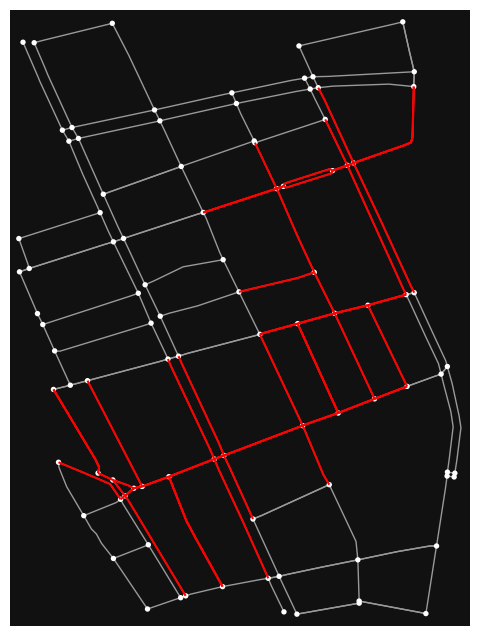

In [49]:
smallnetwork = mm_utils.df_to_network(tripdata_nodes, as_gdf = False)
fig, ax = ox.plot_graph(smallnetwork, figsize=(16,8), show=False, close=False)
all_candidate_edges.plot(ax=ax, color='red')
plt.plot();
#ax.set_title('Road Network')

In [46]:
%%time

print('Least Squares Runtime')

sim2.preprocessing(tripdata_edges, candidate_routes = candidate_routes, n = 1)

Least Squares Runtime


KeyboardInterrupt: 

In [21]:
%%time
sim2_results = sim2.run(k1 = 10, k2 = 10, return_results = True,parallel = True)[0]

CPU times: user 1.25 s, sys: 12.6 ms, total: 1.26 s
Wall time: 1.26 s


In [22]:
%%time
import dask

print('Inverse Squares Runtime')

sim3_results = []

for i in range(10):
    sim = metric_mm.Sim(loss_function = is_loss_function)
    sim3_results.append(dask.delayed(sim.run)(k1 = -1, k2 = -1, return_results = True, parallel = True, preprocessed = False, input_edges = tripdata_edges, network_edges = gdf_edges, candidate_routes = candidate_routes, n = 1))

sim3_results = dask.compute(*sim3_results)

Inverse Squares Runtime
CPU times: user 8min 14s, sys: 1min 9s, total: 9min 24s
Wall time: 6min 24s


In [ ]:
%%time

print('Wasserstein Runtime')
loss = []
sim4.preprocessing(tripdata_edges, candidate_routes = candidate_routes,n=1,m=2)
sim4_results = sim4.run(k1 = 0, k2 = 3, return_results = True, parallel = True)[0]



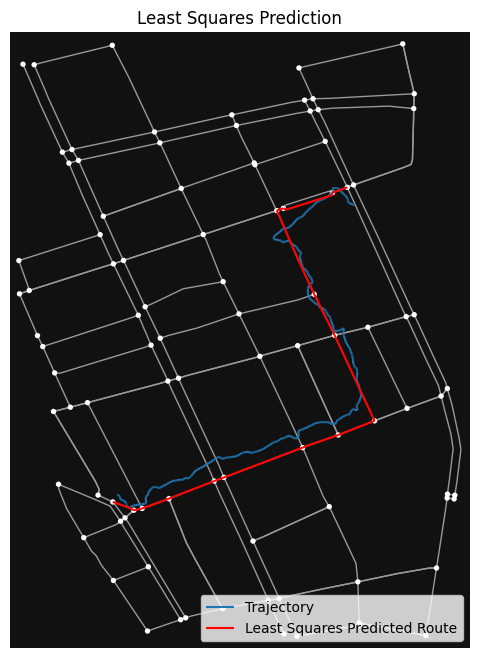

In [28]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim2_results, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trajectory','Least Squares Predicted Route'], loc = 'lower right')
plt.gca().set_title('Least Squares Prediction')
plt.show();

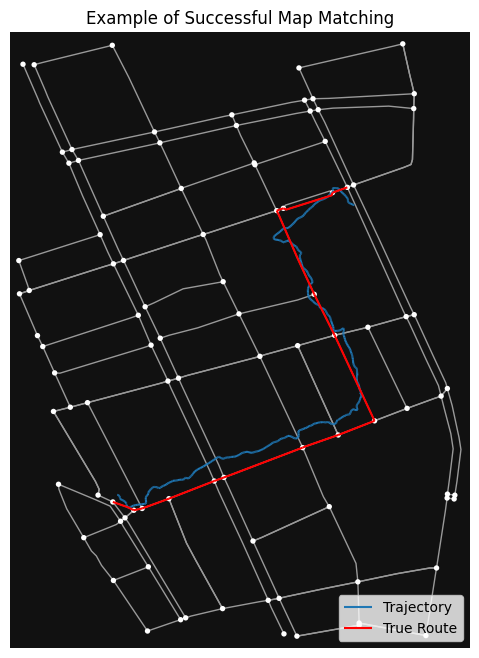

In [37]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim2_results, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trajectory','True Route'], loc = 'lower right')
plt.gca().set_title('Example of Successful Map Matching')
plt.show();

Text(0.5, 1.0, 'Electric Method Prediction')

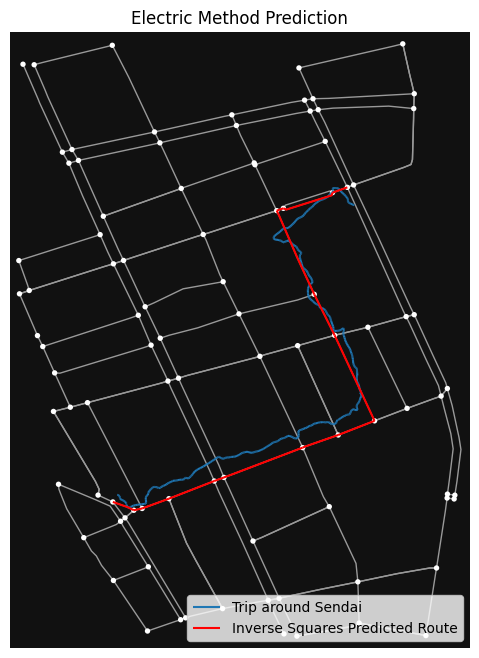

In [38]:
mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim3_results[0][0], fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','Inverse Squares Predicted Route'], loc = 'lower right')
plt.gca().set_title('Electric Method Prediction')

In [ ]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim4_results, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','Wasserstein Predicted Route'], loc = 'lower right')
plt.gca().set_title('Wasserstein Prediction')